Task 1: Data Filtering

In [4]:
%pip install "dask[dataframe]" pandas langdetect

# Install NLP and Plotting libraries
%pip install spacy nltk wordcloud seaborn matplotlib

# Download the English language model for spaCy
!python -m spacy download en_core_web_sm

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
     ---------------------------------------- 0.0/41.5 kB ? eta -:--:--
     ---------------------------------------- 41.5/41.5 kB ? eta 0:00:00
  Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/114.6 kB ? eta -:--:--
     -------------------------------------- 114.6/114.6 kB 7.0 MB/s eta 0:00:00
  Using cached kiwisolver-1.4.9-cp312-cp312-win_amd64.whl.metadata (6.4 kB)
  Using cached pyparsing-3.2.5-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/14.2 MB ? eta -:--:--
   - -------------------------------------- 0.5/14.2 MB 11.4 MB/s eta 0:00:02
   --- ------------------------------------ 1.4/14.2 MB 15.0 MB/s eta 0:00:01
   ------ --------------------------------- 2.2/14.2 MB 15.4 MB/s eta 0:00:01
   -------- ------------------------------- 3.0/14.2 MB 


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------- 0.0/12.8 MB 991.0 kB/s eta 0:00:13
     --------------------------------------- 0.0/12.8 MB 991.0 kB/s eta 0:00:13
     --------------------------------------- 0.1/12.8 MB 525.1 kB/s eta 0:00:25
     --------------------------------------- 0.1/12.8 MB 711.9 kB/s eta 0:00:18
      --------------------------------------- 0.3/12.8 MB 1.3 MB/s eta 0:00:10
      --------------------------------------- 0.3/12.8 MB 1.3 MB/s eta 0:00:10
      --------------------------------------- 0.3/12.8 MB 1.3 MB/s eta 0:00:10
     -- ------------------------------------- 0.6/12.8 MB 1.6 MB/s eta 0:00:08
     ---- ----------------------------------- 1.3/12.8 MB 3.0 MB/s eta 0:00:


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


Loading data from ../../data/filtered_reviews.csv...
Loaded 193166 reviews.
Starting text preprocessing (this may take a few minutes)...
Preprocessing complete!
Generating Word Cloud...


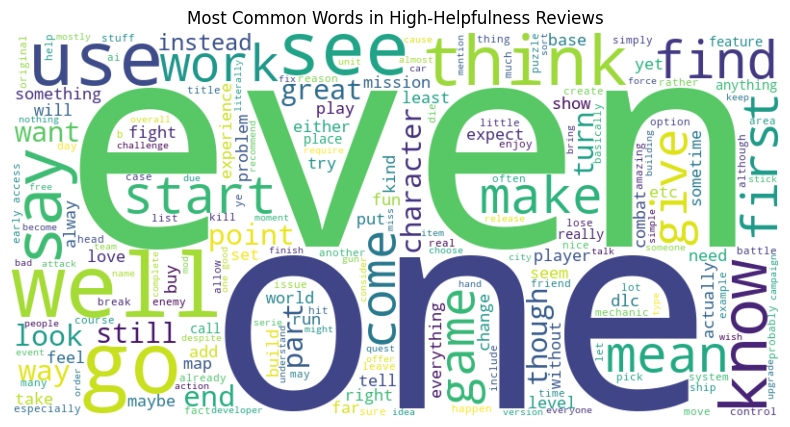

Generating Frequency Plot...


C:\Users\olive\AppData\Local\Temp\ipykernel_39488\1222669617.py:96: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=words_df, x='Frequency', y='Word', palette='viridis')


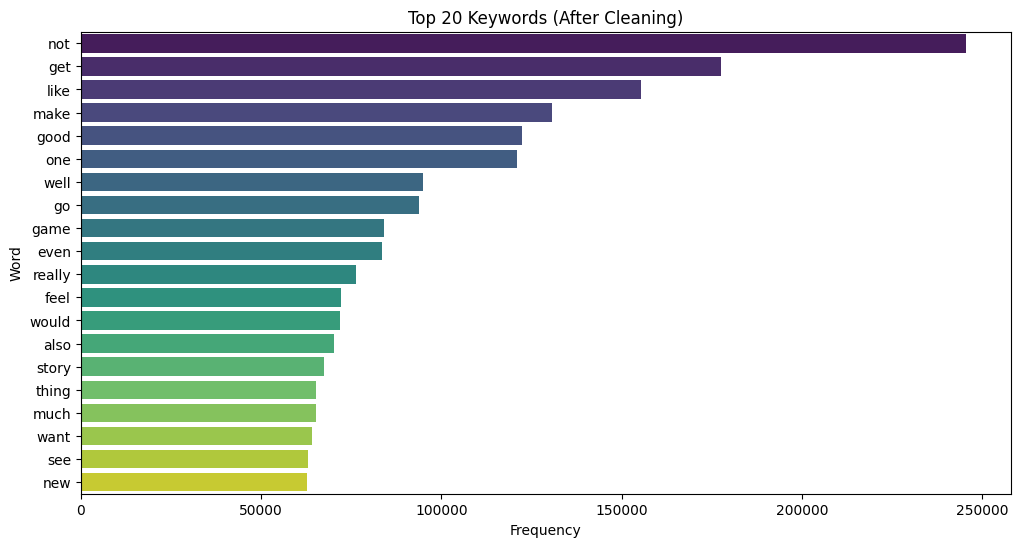

Generating Correlation Heatmap...


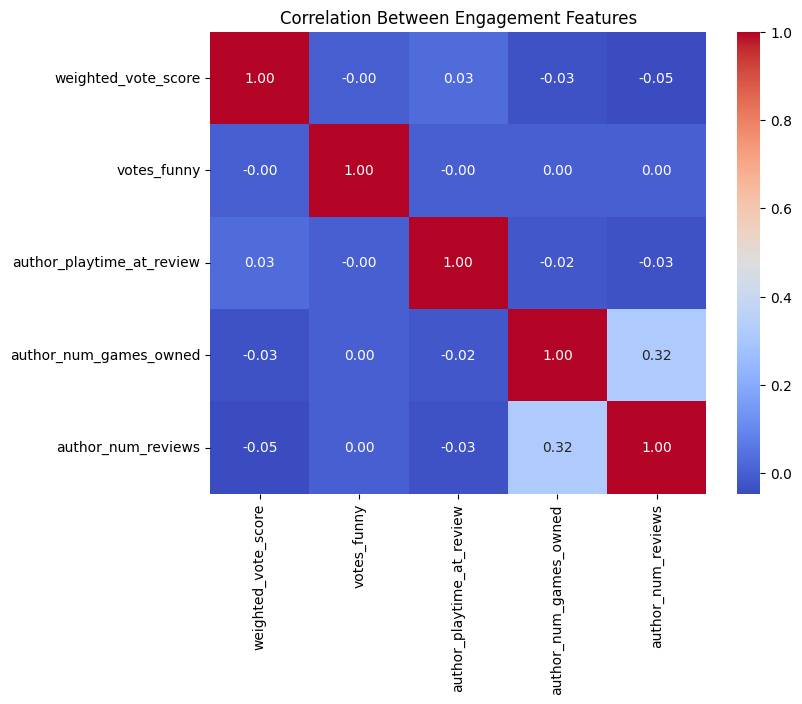

Saved processed data to ../../data/processed_text.csv


In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import nltk
import re
from nltk.corpus import stopwords
from collections import Counter
from wordcloud import WordCloud

# CONFIGURATION
# Establish input and output files
INPUT_FILE = '../../data/filtered_reviews.csv'
OUTPUT_FILE = '../../data/processed_text.csv'

# Load the English model for spaCy (lemmatization)
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner']) # Disable parser/ner for speed

# Download NLTK stopwords
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

# Add custom stopwords specific to gaming/Steam if needed
custom_stops = {'game', 'play', 'played', 'hour', 'time', 'steam'} 
stop_words.update(custom_stops)

# 1. Load data and define ML problem
print(f"Loading data from {INPUT_FILE}...")
df = pd.read_csv(INPUT_FILE)

# Quick check to ensure no empty reviews slipped through
df = df.dropna(subset=['review'])
print(f"Loaded {len(df)} reviews.")

# 2. Text Preprocessing Function (Lowercase, remove special characters/numbers, tokenize, lemmatize, and remove stopwords 
def preprocess_text(text):
    # Lowercase & basic cleanup via Regex
    text = str(text).lower()
    text = re.sub(r'[^a-z\s]', '', text)
    
    # Process with spaCy
    doc = nlp(text)
    
    # Lemmatize and filter stopwords
    cleaned_tokens = [token.lemma_ for token in doc if token.text not in stop_words and not token.is_space]
    
    return " ".join(cleaned_tokens)

print("Starting text preprocessing (this may take a few minutes)...")

# Apply the function to the 'review' column
df['cleaned_review'] = df['review'].apply(preprocess_text)

print("Preprocessing complete!")

# 3. Word Cloud
print("Generating Word Cloud...")
all_text = " ".join(df['cleaned_review'])

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Common Words in High-Helpfulness Reviews')
plt.show()

# 4. Keyword Frequency Plot
print("Generating Frequency Plot...")
# Split all cleaned reviews into a giant list of words
all_words = " ".join(df['cleaned_review']).split()
word_freq = Counter(all_words)

# Get top 20 words
common_words = word_freq.most_common(20)
words_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])

plt.figure(figsize=(12, 6))
sns.barplot(data=words_df, x='Frequency', y='Word', palette='viridis')
plt.title('Top 20 Keywords (After Cleaning)')
plt.show()

# 5. Correlation Heatmap
print("Generating Correlation Heatmap...")

# Select only numerical columns for correlation
numeric_cols = [
    'weighted_vote_score', 'votes_funny', 'author_playtime_at_review', 
    'author_num_games_owned', 'author_num_reviews'
]

# Calculate correlation matrix
corr = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between Engagement Features')
plt.show()

# 6. Save Output
# Save the dataset with the new 'cleaned_review' column
df.to_csv(OUTPUT_FILE, index=False)
print(f"Saved processed data to {OUTPUT_FILE}")